# Imports

In [1]:
import logging
from contextlib import contextmanager

import numpy as np

from khan_helpers import Experiment
from khan_helpers.constants import (
    FIG_DIR, 
    BOS_LECTURE_COLOR, 
    BOS_QUESTION_COLOR, 
    FORCES_LECTURE_COLOR, 
    FORCES_QUESTION_COLOR,
    GENERAL_QUESTION_COLOR
)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Define functions

In [2]:
@contextmanager
def disable_logging(module, level='CRITICAL'):
    """
    temporarily disable logging from `module` for messages less severe 
    than `level`.
    """
    
    if module not in logging.root.manager.loggerDict:
        raise ValueError(f"no logger exists for module '{module}'")
        
    logger = logging.getLogger(module)
    old_level = logger.level
    logger.setLevel(level.upper())
    try:
        yield
    finally:
        logger.setLevel(old_level)

# Load data, set constants

In [3]:
exp = Experiment()

GRID_RESOLUTION = 100
CMAP = 'bone'
LECTURE_LINEWIDTH = 1.5
QUESTION_SIZE = 40

# Uniformly shift embeddings to line up with heatmap bounds for plotting

In [4]:
embeddings = np.vstack((exp.forces_embedding, 
                        exp.bos_embedding, 
                        exp.question_embeddings))

# create a 2D grid over the embedding space
x_min, y_min = embeddings.min(axis=0) // 1 - 3
x_max, y_max = embeddings.max(axis=0) // 1 + 3

xs = np.linspace(x_min, x_max, GRID_RESOLUTION, endpoint=True)
ys = np.linspace(y_min, y_max, GRID_RESOLUTION, endpoint=True)

vertices = np.array([(x_coord, y_coord) for y_coord in ys for x_coord in xs])

all_coords = [exp.forces_embedding, 
              exp.bos_embedding, 
              exp.question_embeddings, 
              vertices]
split_inds = np.cumsum([arr.shape[0] for arr in all_coords])[:-1]
shifted = np.vstack(all_coords)
shifted -= shifted.min(axis=0)
shifted /= (shifted.max(axis=0) / GRID_RESOLUTION)

forces_lecture, bos_lecture, questions = np.vsplit(shifted, split_inds)[:-1]
forces_qs, bos_qs, general_qs = np.split(questions, (15, 30))

# Plot individual knowledge maps for each quiz, separately

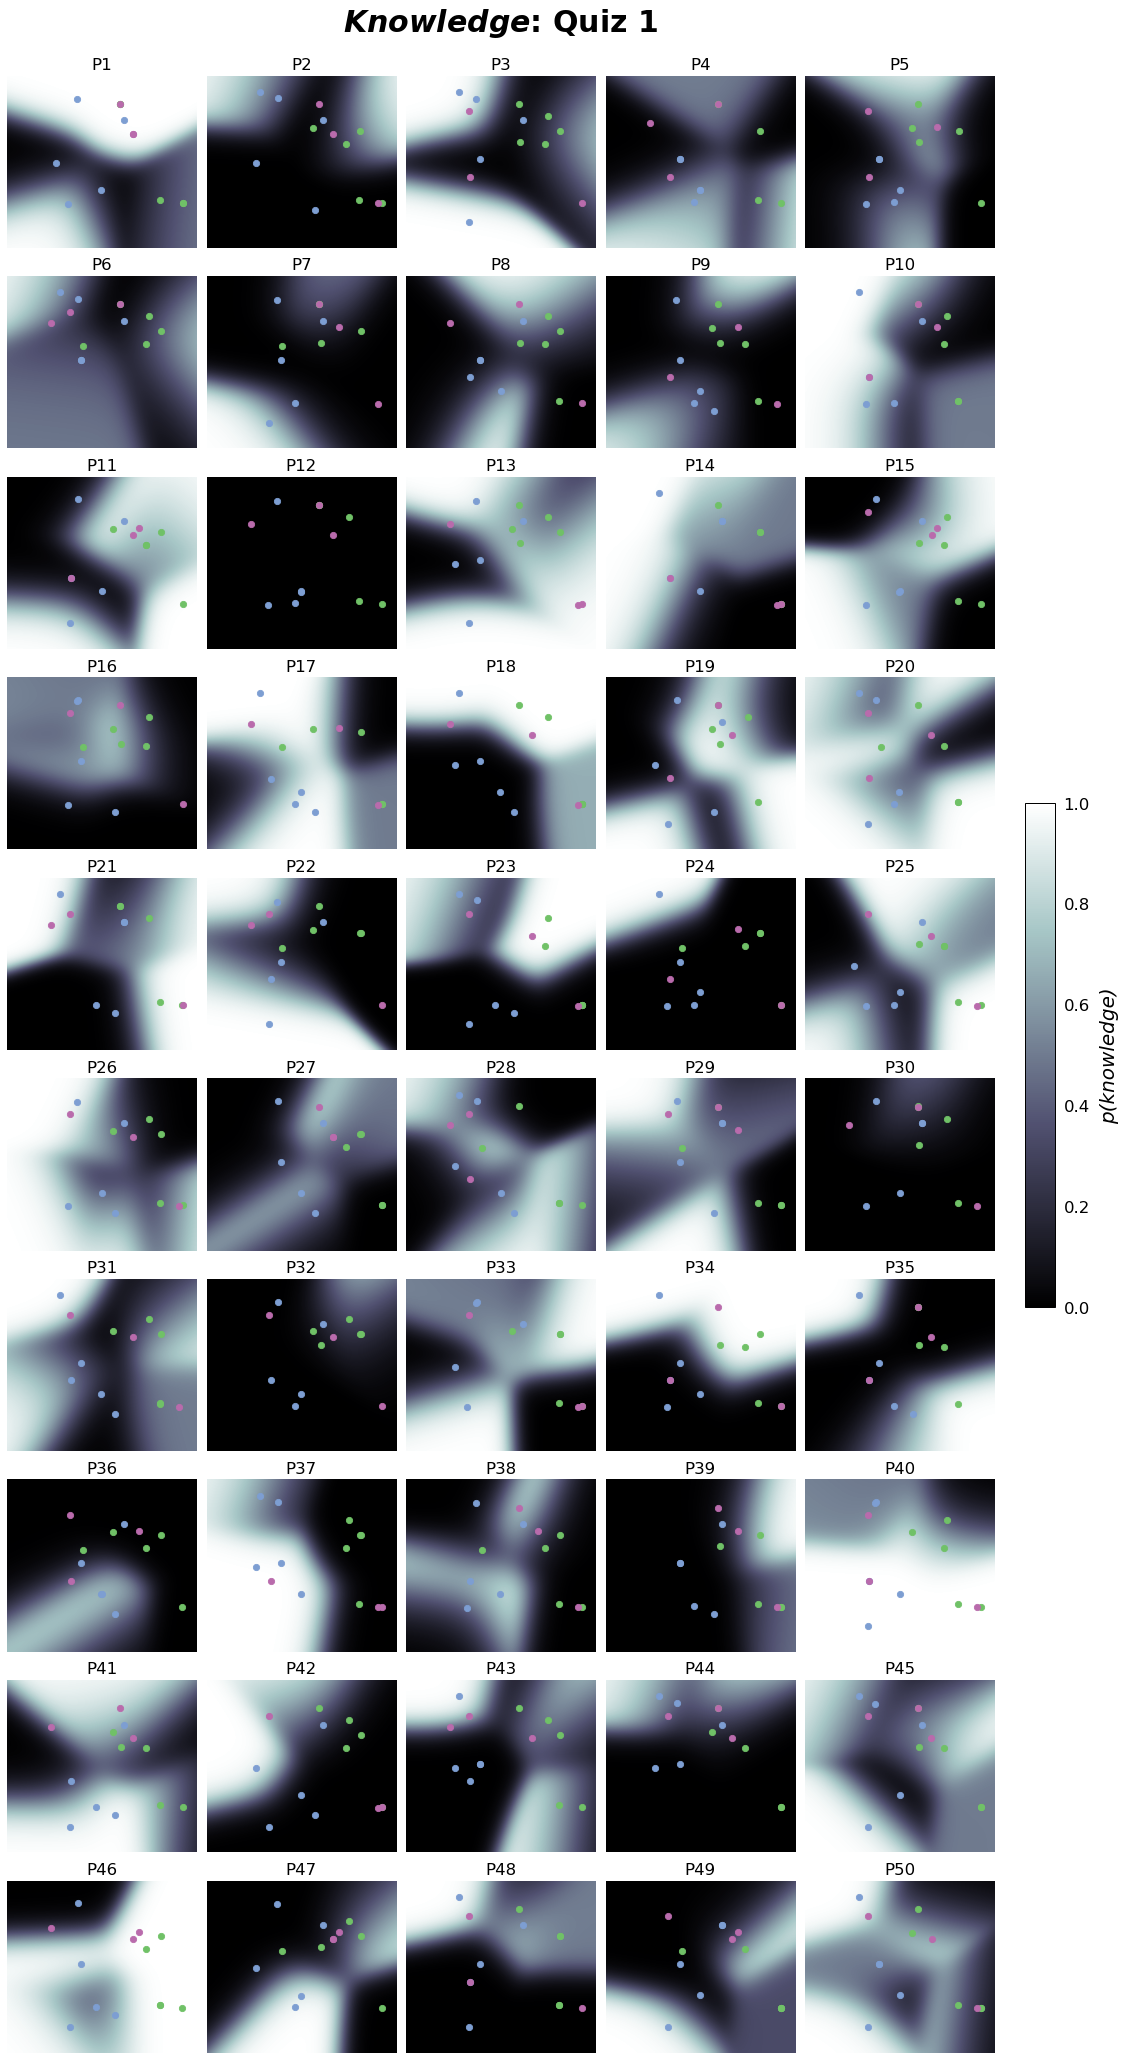

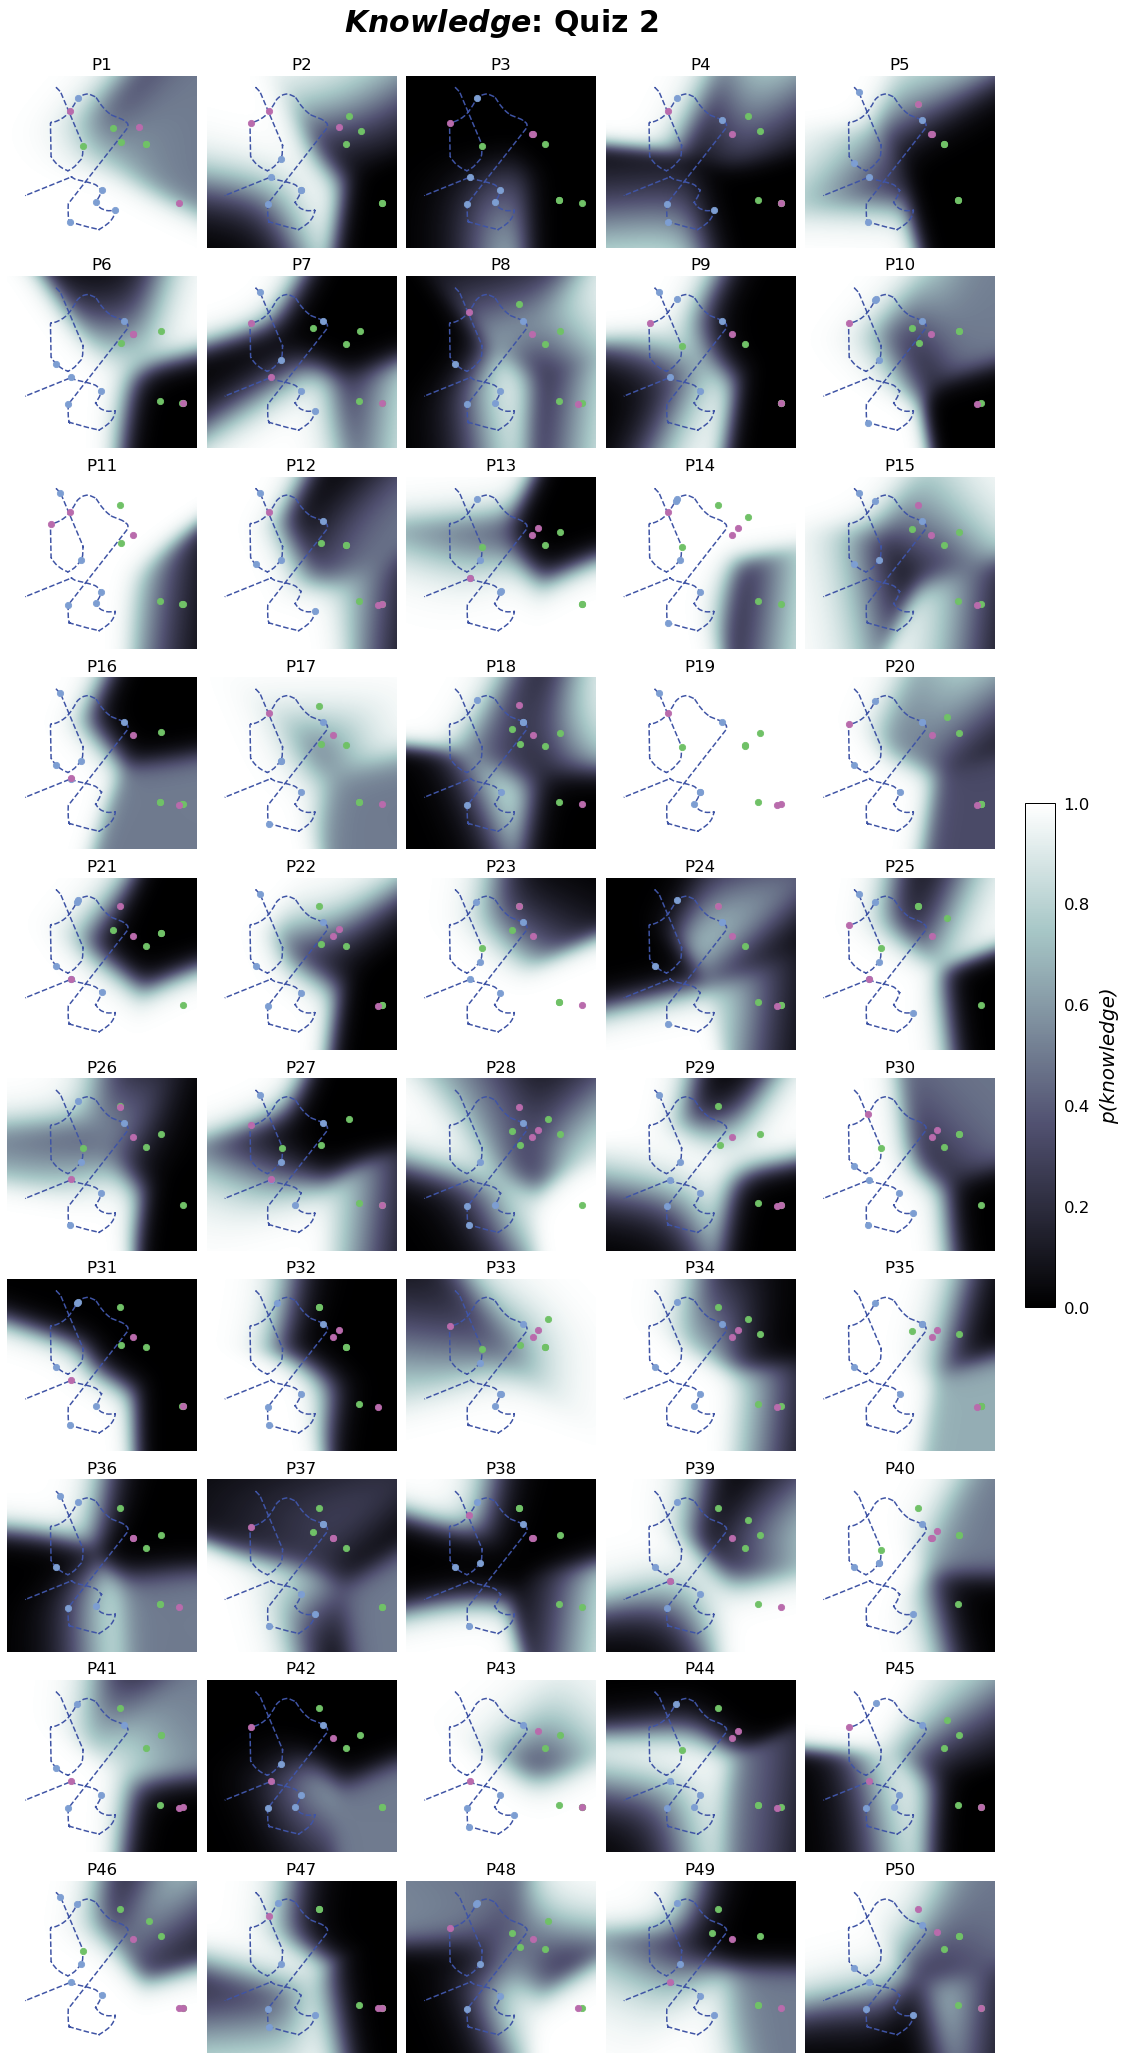

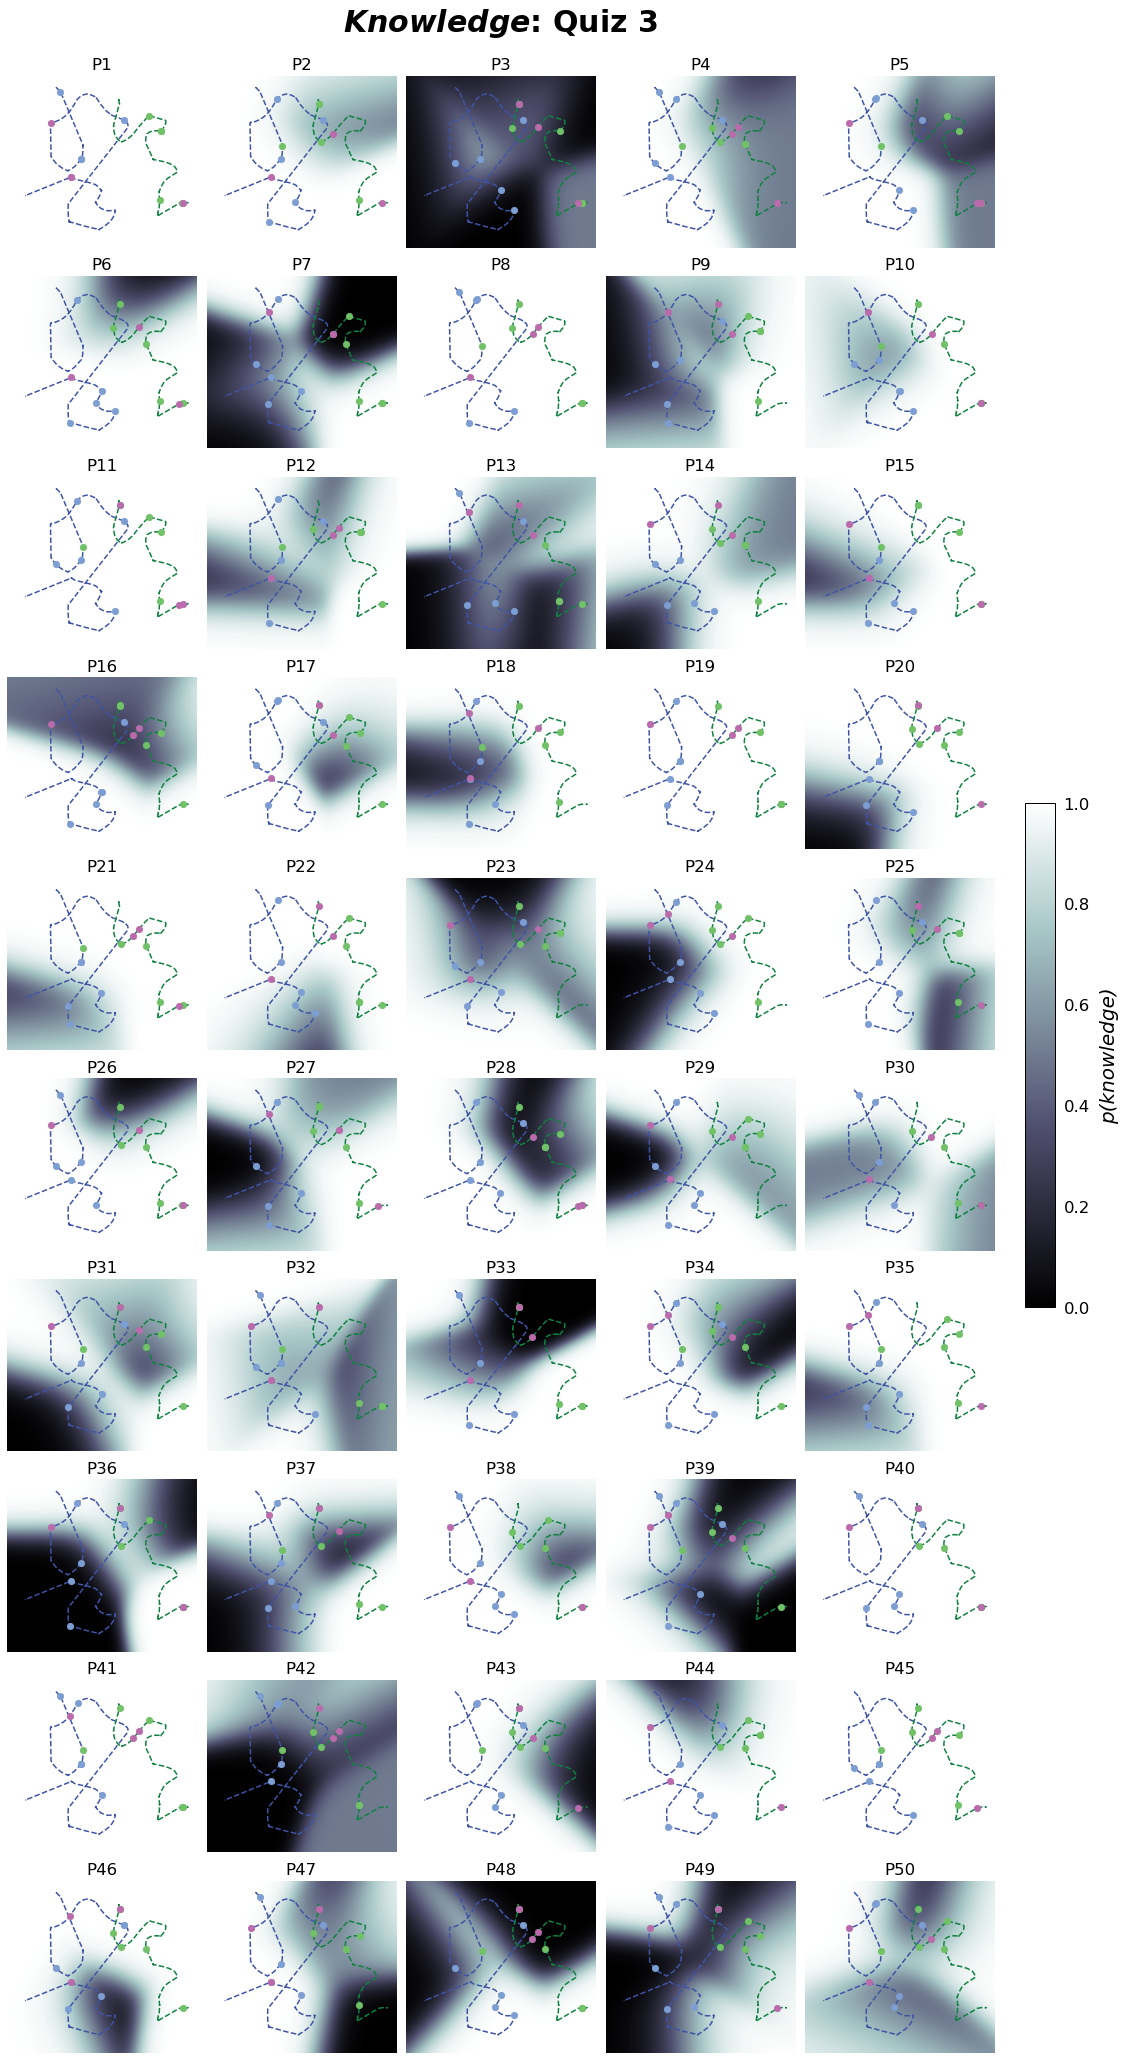

In [5]:
with sns.plotting_context('paper'):
    for quiz in range(1, 4):
        fig, axarr = plt.subplots(10, 5, figsize=(14, 28))
        axarr = axarr.flatten()
        
        for p, ax in zip(exp.participants, axarr):
            # get participant's knowledge map for this quiz
            kmap = p.knowledge_maps[f'forces_bos_quiz{quiz}']
            # get questions participant answered on this quiz
            general_qids, forces_qids, bos_qids = (p.get_data(quiz=quiz-1)
                                                   .set_index('qID')
                                                   .groupby('lecture')
                                                   .groups.values())

            # knowledge estimate heatmap
            ax.imshow(kmap,
                      vmin=0,
                      vmax=1,
                      aspect='auto',
                      cmap=CMAP,
                      interpolation='bilinear')
            # Four Fundamental Forces quiz questions
            ax.scatter(questions[forces_qids - 1, 0],
                       questions[forces_qids - 1, 1],
                       c=FORCES_QUESTION_COLOR,
                       marker='o',
                       s=QUESTION_SIZE,
                       zorder=2)
            # Birth of Stars quiz questions
            ax.scatter(questions[bos_qids - 1, 0], 
                       questions[bos_qids - 1, 1], 
                       c=BOS_QUESTION_COLOR, 
                       marker='o', 
                       s=QUESTION_SIZE, 
                       zorder=2)
            # general physics knowledge quiz questions
            ax.scatter(questions[general_qids - 1, 0],
                       questions[general_qids - 1, 1],
                       c=GENERAL_QUESTION_COLOR,
                       marker='o',
                       s=QUESTION_SIZE,
                       zorder=2)
            # Four Fundamental Forces lecture trajectory
            if quiz > 1:
                ax.plot(forces_lecture[:, 0], 
                        forces_lecture[:, 1], 
                        c=FORCES_LECTURE_COLOR,
                        linestyle='--', 
                        linewidth=LECTURE_LINEWIDTH, 
                        zorder=1)
                # Birth of Stars lecture trajectory
                if quiz == 3:
                    ax.plot(bos_lecture[:, 0], 
                            bos_lecture[:, 1], 
                            c=BOS_LECTURE_COLOR,
                            linestyle='--',
                            linewidth=LECTURE_LINEWIDTH, 
                            zorder=1)

            ax.axis('off')
            ax.set_title(p.subID, fontsize='xx-large')
            # undo automatic y-axis inversion from sns.heatmap
            ax.invert_yaxis()

        # call tight_layout before adding colorbar
        plt.tight_layout()
        
        cbar_ax = fig.add_axes((1.02, 0.375, 0.03, 0.25))
        cbar = fig.colorbar(ax.images[0], cax=cbar_ax)
        cbar_ax.tick_params(right=False, labelsize='xx-large')
        cbar.set_label('p(knowledge)', size=20, labelpad=10, style='italic')
            
        with (
            # temporarily suppress harmless logged warnings:
            #     findfont: Font family ['cursive'] not found. Falling 
            #     back to DejaVu Sans.
            # and
            #     findfont: Generic family 'cursive' not found because 
            #     none of the following families were found: Apple 
            #     Chancery, Textile, Zapf Chancery, Sand, Script MT, 
            #     Felipa, Comic Neue, Comic Sans MS, cursive
            #
            # need to set 'mathtext.fontset' = 'custom' in order to set
            # 'mathtext.bf', but when 'mathtext.fontset' = 'custom',
            # matplotlib also tries to set 'mathtext.cal' = 'cursive'
            # internally and issues a warning because no cursive font 
            # families are installed in analysis container
            disable_logging('matplotlib.font_manager', 'ERROR'), 
            # make \mathit{} font bold & italic
            plt.rc_context({
                'mathtext.fontset': 'custom', 
                'mathtext.it': 'sans:bold:italic'
            })
        ):
            fig.suptitle(f'$\\mathit{{Knowledge}}$: Quiz {quiz}', 
                         y=1.02, 
                         fontsize=30,
                         fontweight='bold')
#             plt.savefig(FIG_DIR.joinpath(f'individual-knowledge-maps-quiz{quiz}.pdf'), 
#                         bbox_inches='tight', 
#                         dpi=150)
            plt.show()

# Plot individual learning maps

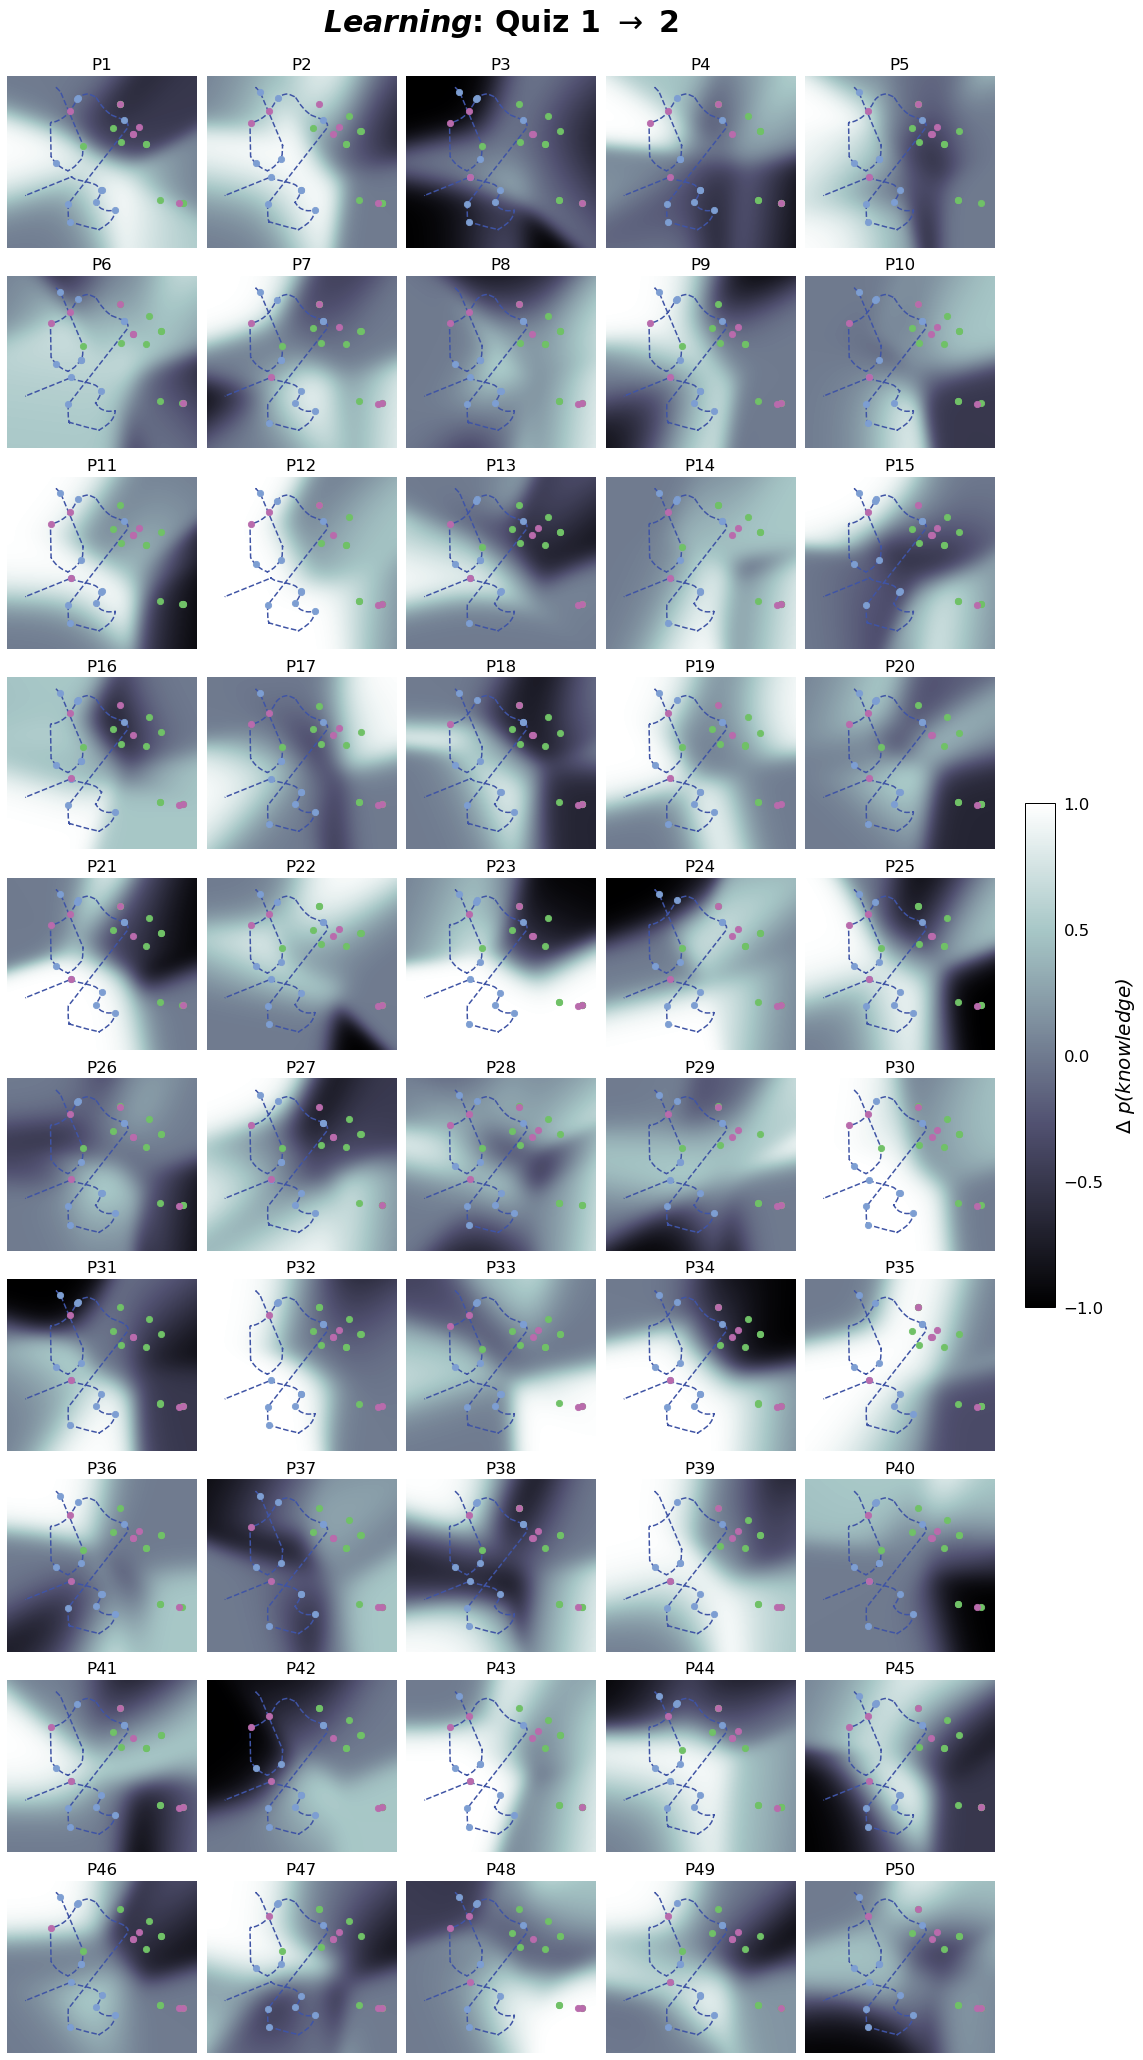

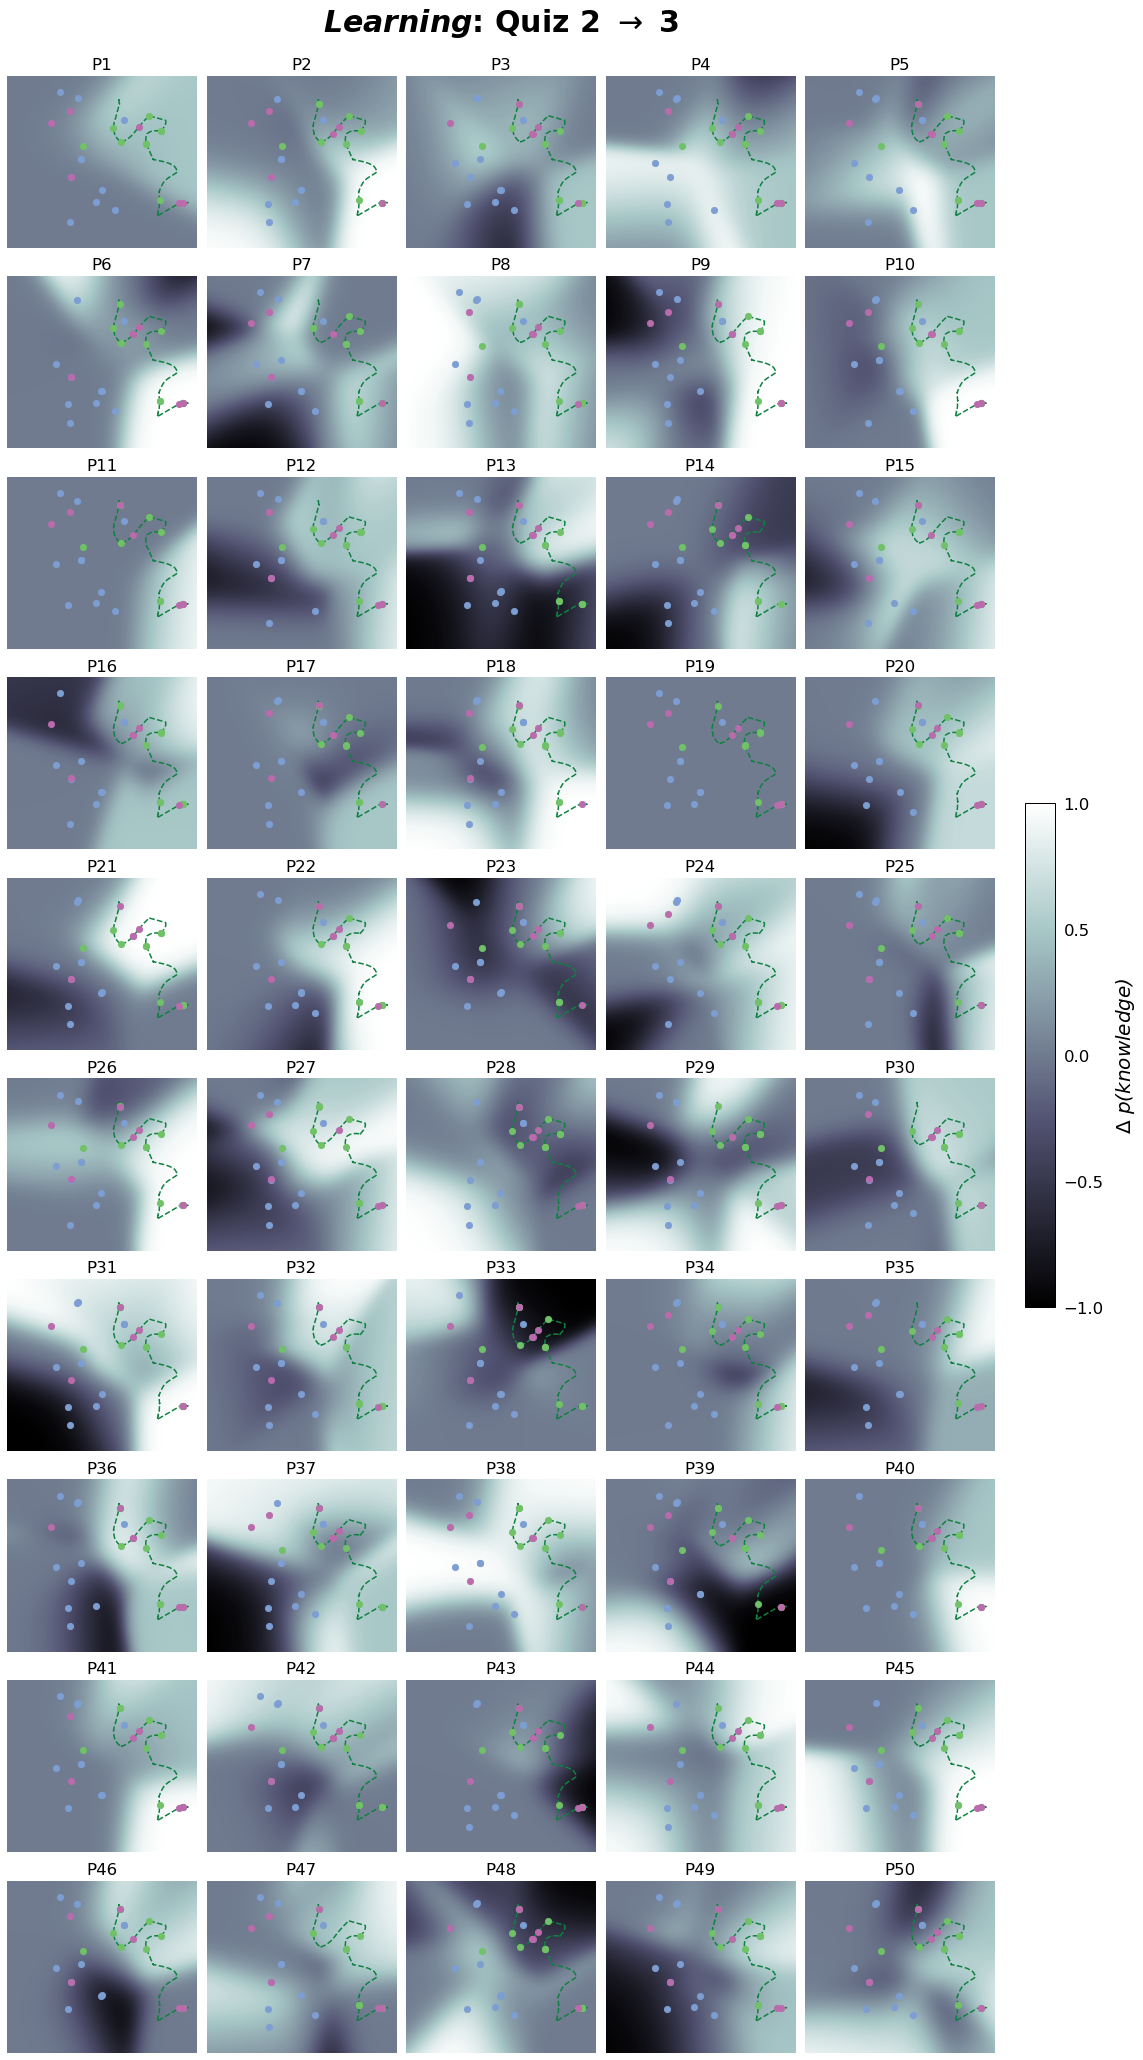

In [6]:
with sns.plotting_context('paper'):
    for quiz in range(1, 3):
        fig, axarr = plt.subplots(10, 5, figsize=(14, 28))
        axarr = axarr.flatten()
        
        for p, ax in zip(exp.participants, axarr):
            # get participant's knowledge maps for two consecutive quizzes
            kmap_before = p.knowledge_maps[f'forces_bos_quiz{quiz}']
            kmap_after = p.knowledge_maps[f'forces_bos_quiz{quiz + 1}']
            # learning map is the change in knowledge at each coordinate
            lmap = kmap_after - kmap_before
            # get questions participant answered on both quizzes
            quiz_data = p.get_data(quiz=(quiz-1, quiz))
            general_qids, forces_qids, bos_qids = (quiz_data
                                                   .set_index('qID')
                                                   .groupby('lecture')
                                                   .groups.values())
            
            # knowledge estimate heatmap
            ax.imshow(lmap,
                      vmin=-1,
                      vmax=1,
                      aspect='auto',
                      cmap=CMAP,
                      interpolation='bilinear')
            # Four Fundamental Forces quiz questions
            ax.scatter(questions[forces_qids - 1, 0],
                       questions[forces_qids - 1, 1],
                       c=FORCES_QUESTION_COLOR,
                       marker='o',
                       s=QUESTION_SIZE,
                       zorder=2)
            # Birth of Stars quiz questions
            ax.scatter(questions[bos_qids - 1, 0], 
                       questions[bos_qids - 1, 1], 
                       c=BOS_QUESTION_COLOR, 
                       marker='o', 
                       s=QUESTION_SIZE, 
                       zorder=2)
            # general physics knowledge quiz questions
            ax.scatter(questions[general_qids - 1, 0],
                       questions[general_qids - 1, 1],
                       c=GENERAL_QUESTION_COLOR,
                       marker='o',
                       s=QUESTION_SIZE,
                       zorder=2)
            # Four Fundamental Forces lecture trajectory
            if quiz == 1:
                ax.plot(forces_lecture[:, 0], 
                        forces_lecture[:, 1], 
                        c=FORCES_LECTURE_COLOR,
                        linestyle='--', 
                        linewidth=LECTURE_LINEWIDTH, 
                        zorder=1)
            # Birth of Stars lecture trajectory
            else:
                ax.plot(bos_lecture[:, 0], 
                        bos_lecture[:, 1], 
                        c=BOS_LECTURE_COLOR,
                        linestyle='--',
                        linewidth=LECTURE_LINEWIDTH, 
                        zorder=1)
            
            ax.axis('off')
            ax.set_title(p.subID, fontsize='xx-large')
            # undo automatic y-axis inversion from sns.heatmap
            ax.invert_yaxis()

        # call tight_layout before adding colorbar
        plt.tight_layout()
        
        cbar_ax = fig.add_axes((1.02, 0.375, 0.03, 0.25))
        cbar = fig.colorbar(ax.images[0], 
                            cax=cbar_ax, 
                            ticks=np.linspace(-1, 1, 5))
        cbar_ax.tick_params(right=False, labelsize='xx-large')
        cbar.set_label('$\mathit{\Delta}$ p(knowledge)', 
                       size=20, 
                       labelpad=10, 
                       style='italic')
        
        with (
            # temporarily suppress harmless logged warnings:
            #     findfont: Font family ['cursive'] not found. Falling 
            #     back to DejaVu Sans.
            # and
            #     findfont: Generic family 'cursive' not found because 
            #     none of the following families were found: Apple 
            #     Chancery, Textile, Zapf Chancery, Sand, Script MT, 
            #     Felipa, Comic Neue, Comic Sans MS, cursive
            #
            # need to set 'mathtext.fontset' = 'custom' in order to set
            # 'mathtext.bf', but when 'mathtext.fontset' = 'custom',
            # matplotlib also tries to set 'mathtext.cal' = 'cursive'
            # internally and issues a warning because no cursive font 
            # families are installed in analysis container
            disable_logging('matplotlib.font_manager', 'ERROR'), 
            # make \mathit{} font bold & italic
            plt.rc_context({
                'mathtext.fontset': 'custom', 
                'mathtext.it': 'sans:bold:italic'
            })
        ):
            fig.suptitle(f'$\\mathit{{Learning}}$: Quiz {quiz} $\\rightarrow$ {quiz + 1}', 
                         y=1.02, 
                         fontsize=30,
                         fontweight='bold')
#             plt.savefig(FIG_DIR.joinpath(f'individual-learnings-maps-quiz{quiz}-{quiz + 1}.pdf'), 
#                         bbox_inches='tight', 
#                         dpi=150)
            plt.show()